# Lab 1: Recreating a Time Series El Niño Study
### Joe Barry
### March 1, 2021

## Introduction

In this lab, we will use meteorological and humanitarian data relating to the El Niño Southern Oscillation cycle, or ENSO, in order to reproduce findings from the paper on the same topic by Lam et al. The focus of this paper, ENSO, is the cycle between El Niño and La Niña events. El Niño and La Niña are meteorological phenomena which take place in the Southern Pacific Ocean and bring warmer and cooler sea surface temperatures, respectively, to the region. The result of these changes over such a large area of the Earth are felt worldwide (CPC 2005).

ENSO is quantified in the paper using two indices which estimate the severity of these events: the Oceanic Niño Index (ONI) and the multivariate El Niño Index (MEI) the goal of the paper was to find the correlation between the appearance of these events and the number of people who were affected by meteorological disasters, such as droughts, floods, and storms. Analyses like this can help us track the patterns of ENSO in order to better prepare for its effects.


In the paper, time series analysis techniques were used to find the relationship between the number of people affected by disasters (PAD) and the indices previously mentioned (ONI and MEI). PAD rates were regressed over each index using Poisson Generalized Additive Models (GAMs) and distributed-lag non-linear models.


While many of the findings were not statistically significant, they did find that flood-related PADs were significantly correlated with moderate El Niño and La Niña events, and drought related PADs were strongly correlated with moderate El Niño events. These correlations were most drastic in the Philippines and India (Lam et al. 2019). 


## Methods

First, we must import needed libraries.

In [17]:
install.packages('tswge')
library('tswge')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘signal’, ‘PolynomF’, ‘waveslim’, ‘astsa’




Much of the code necessary to load the MEI, ONI, and PAD data into R was provided. Here are those methods:

### Code provided

First, we need to load and process the ONI data.

In [1]:
#Define the URL, scrub the file name from the URL and download to /tmp
oni.url <- "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni.name <- tail(unlist(strsplit(oni.url, "/")), n=1)
oni.file <- paste("/tmp/", oni.name, sep="")
download.file(oni.url, oni.file, method = 'auto')

# Read directly to dataframe preserving the header
oni.df <- read.table(oni.file, header = TRUE)

# Turn anomalies into a time series object
oni.ts <- ts(oni.df$ANOM, start = c(1950, 1), frequency = 12)

# Filter the data frame for our month of interest for each year
oni.filt <- subset(oni.df, SEAS == 'DJF')
oni.filt <- subset(oni.filt, YR > 1963 & YR < 2018)

Next, the MEI data.

In [2]:
# Define the URL, scrub the file name, and download it to /tmp
mei.url <- "https://psl.noaa.gov/enso/mei.old/table.html"
mei.name <- tail(unlist(strsplit(mei.url, "/")), n=1)
mei.file <- paste("/tmp/", mei.name, sep="")
download.file(mei.url, mei.file, method = 'auto')

# Read the column names from the data
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^YEAR.*", my.line)
  if (length(a) > 0) {
    my.cols <- unlist(strsplit(my.line, "\\s+"))
  }
}

# Create an empty dataframe
n.cols <- length(my.cols)
mei.df <- data.frame(matrix(ncol = n.cols, nrow = 0))
colnames(mei.df) <- my.cols 

# Get all the data lines
a <- readLines(mei.file)
for (my.line in a){
  a <- grep("^[0-9].*", my.line)
  if (length(a) > 0) {
    my.data <- unlist(strsplit(my.line, "\\s+"))
    num.data <- length(my.data)
    if (num.data == n.cols) {
      my.values <- c()
      for (d in my.data) {
        my.values <- append(my.values, as.numeric(d))
      }
      mei.df[nrow(mei.df)+1,] = my.values
    }
  }
}

# Convert the last twelve columns into a row-by-row vector
# then feed that into the time series function
mei.ts <- ts(as.vector(t(mei.df[,2:length(my.cols)])), start = c(1950, 1), frequency = 12)

Lastly, the PAD data. Note that this data is accessed locally and not by URL, so that must be imported first (all local data is provided with the lab).

In [3]:
pad.file <- "/tmp/joebarry1_emdat.csv"
pad.df.all <- read.csv(pad.file, header=TRUE, skip=6)

# Retrieve fields mentioned in paper, including:
# - number of people killed (Total.Deaths)
# - declaration of state of emergency (Declaration)
# - international assistance (OFDA.Response)
# - total affected
cols.interest <- c("Country", "ISO", "Start.Year", "Start.Month", 
                   "End.Year", "End.Month", "Total.Deaths", "Declaration", 
                   "OFDA.Response", "Total.Affected")
pad.df <- pad.df.all[cols.interest]

Now we need to import the population data:

In [4]:
# Download the zip of our table data
wbank.url <- "http://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=csv"
wbank.name <- "world_bank.zip"
wbank.file <- paste("/tmp/", wbank.name, sep="")
download.file(wbank.url, wbank.file)
unzip(zipfile = wbank.file, exdir = "/tmp")

# Find the CSV with country total populations from all the unzipped files.
my.file <- ""
for (tmp.file in list.files("/tmp")){
  a <- grep("^API_SP.POP.TOTL.*csv", tmp.file)
  if (length(a) > 0) {
    my.file <- tmp.file
  }
}

# Add the path back to the file name
wb.file <- paste("/tmp/", my.file, sep="")
wb.df <- read.csv(wb.file, header = TRUE, skip = 4)

# Loop through each row of our data frame and
# find the matching country and year
# remember that year columns in World Bank start with "X"
# and save the population to the original pad dataframe.
for (i in 1:nrow(pad.df)) {
  # Remember i is the row index in pad.df
  tmp.iso <- pad.df[i, ][['ISO']]
  tmp.year <- pad.df[i, ][['Start.Year']]
  tmp.col <- paste("X", tmp.year, sep="")
  # Match returns "NA" if no match
  a <- match(tmp.iso, wb.df$Country.Code)
  if (!is.na(a)) {
    tmp.pop <- wb.df[,tmp.col][a]
    # We can create new dataframe columns on the fly
    pad.df[i, 'POP'] = tmp.pop
    #print(c(tmp.iso, tmp.year, tmp.pop))
  } else {
    # Make sure to assign missing values, too!
    pad.df[i, 'POP'] = NA
    #print(paste("Could not match", tmp.iso))
  }
}

### Identifying El Niño Years

Now that all of our data is loaded into data frames and/or time series, we can begin analyzing it. The first step is getting a sense of when El Niño events are occurring. The paper defines an El Niño year as "at least five consecutive overlapping three-month periods" where ONI is higher, or lower, than .5 (Lam et al.). 

In [12]:
#Subsetting the data to our time period
oni.df.set <- subset(oni.df, YR > 1963 & YR < 2018)

#Creating ENSO column
enso.type <- rep(NA, 648)
oni.df.set$ENSO <- enso.type
for (month in 1:(nrow(oni.df.set))) {
  if (oni.df.set[month,4] > 0.5){
    oni.df.set[month,5] <- 'niño'
  }
  else if (oni.df.set[month,4] < -0.5){
    oni.df.set[month,5] <- 'niña'
  }
  else {
    oni.df.set[month,5] <- 'neither'
  }
}

# Identifying the year of El Niño events
# Note that running the print lines will allow us to identify each year of note
ninocounter <- 0
ninacounter <- 0
for (month in 1:(nrow(oni.df.set))) {
  nino <- FALSE
  nina <- FALSE
  if (oni.df.set[month, 5] == 'niño'){
    if (ninacounter > 5) {
      nina <- TRUE
    }
    ninacounter <- 0
    ninocounter <- ninocounter + 1
  }
  else if (oni.df.set[month, 5] == 'niña'){
    if (ninocounter > 5) {
      nino <- TRUE
    }
    ninocounter <- 0
    ninacounter <- ninacounter + 1
  }
  else {
    if (ninocounter > 5) {
      nino <- TRUE
      ocount <- ninocounter
    }
    if (ninacounter > 5) {
      nina <- TRUE
      acount <- ninacounter
    }
    ninocounter <- 0
    ninacounter <- 0
  }
  if (nino){
    #print(paste(oni.df.set[month-ocount,2], 'is an El Niño year!'))
  }
  else if (nina){
    #print(paste(oni.df.set[month-acount,2], 'is a La Niña year!'))
  }
}

Now we have our list: 
- El Niño years: 1965, 1968, 1969, 1972, 1976, 1982, 1986, 1991, 1994, 1997, 2002, 2004, 2009, and 2015.
- La Niña years: 1964, 1970, 1973, 1974, 1984, 1988, 1995, 1998, 2007, 2010, and 2011.

### Reproducing Figure 1

Figure 1 of the paper consists of three scatter plots displaying the data for our three metrics (ONI, MEI, and PAD) over the time scale of the study (1964-2017). Much of the data needed here was already processed. Recreating the graphs mostly involved formatting and labelling.

In [ ]:
#ONI graph
par(fig=c(0.0,1,0.5,1))
plot(
  oni.filt$YR, oni.filt$ANOM, 
  main = "ONI in Dec-Feb 1964-2017", 
  type = "p",
  xlab = "Year",
  ylab = "ONI")
abline(h = 0, lty = 1, lwd = 2)
abline(h = .5, lty=2)
abline(h = -.5, lty=2)

In [ ]:
#MEI graph
#this is the first column in mei.ts, from 1964 to 2017: mei.df[14:68,2]
mei.filt <- mei.df[15:68,2]
par(fig=c(0.0,1,0.5,1))
plot.ts(ts(mei.filt, start = c(1964,1)),
         ylab = 'MEI', 
         main = 'MEI in Dec-Jan 1964-2017', 
         xlab = 'Year', 
         type = 'p'
         )
abline(h=.5, lty=2)
abline(h=-.5, lty=2) 
abline(h=0, lty=1, lwd=2)

For PAD, the code is a bit more involved, because we first need to use our population and disaster data to calculate PAD rates. Note that sample code to convert for a single year was provided, but I altered it to calculate the rates for each year.

In [9]:
pad.filt <- rep(NA, 54)
for (year in 1964:2017) {
  my.pad <- subset(pad.df, Start.Year == year)
  pad <- 0
  for (i in 1:nrow(my.pad)){
    if (!is.na(my.pad$Total.Affected[i]) & !is.na(my.pad$POP[i])) {
      tally <- my.pad$Total.Affected[i]
      pad <- pad + tally
    }
  }
  pop <- 0
  for (my.iso in unique(my.pad$ISO)){
    #print(my.iso)
    a <- match(my.iso, my.pad$ISO)
    tmp.pop <- my.pad$POP[a]
    if (!is.na(tmp.pop)) {
      pop <- pop + tmp.pop
    }
  }
  pad.filt[year-1963] <- (pad/pop)*1000
}

In [ ]:
pad.filt.ts <- ts(pad.filt, start = c(1964, 1))
par(fig=c(0.0,1,0.5,1))
plot.ts(pad.filt.ts, type = 'p', ylab = "PAD", xlab = "Year", main = "PAD (per 1000) 1964-2017")

Note that the exact numbers are not the same as the paper, but the trends are. We have identified the same peak years for PAD rate. This indicates that our methodology is slightly different, but we're realizing the same underlying data.

### US Senate Data

For a dataset which exhibited behavior similar to ENSO, I wanted something which oscillated, albeit irregularly. A good example for this in an area of interest for me was the proportion of the US Senate from each major political party since the Civil War (when the Democratic and Republican parties became the primary two political parties in the US). Note that like the PAD data, the dataset used has been provided locally, and it's source, the United States Senate Historical Office, has been cited.

In [46]:
#Let's load the data
senate.file <- "/tmp/joebarry1_senatedata.csv"
senate.data <- read.csv(senate.file, header=TRUE)

#Since each party is almost perfectly inversely related to the other, we can just model one party.
#Here is a vector of just the Senate Democrats:
dem.ts <- ts(rev(senate.data$Dem), start = c(1856, 2), frequency = 0.5)

The data is now ready to be analyzed.

## Results

A primary goal of this lab is to find some dominant frequencies in semi-periodic time series. In order to aid in doing so, we can use graphs of lagged autocorrelation $\rho_t$ across time $t$, and periodograms.

We will begin by looking at the ONI dataset.

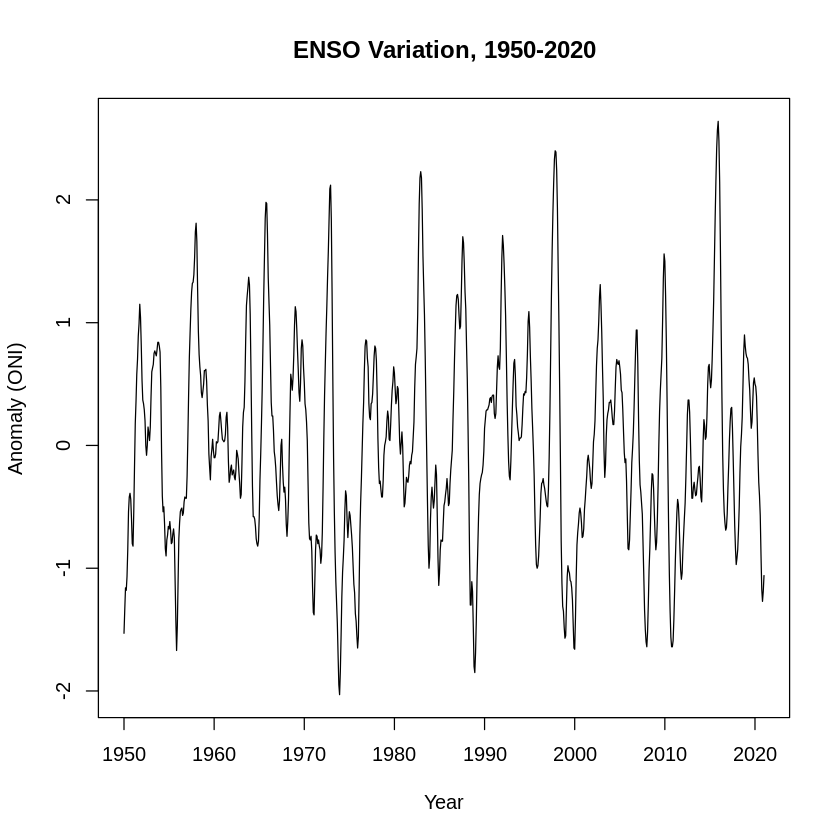

In [14]:
plot.ts(oni.ts, main = "ENSO Variation, 1950-2020", ylab = "Anomaly (ONI)", xlab = "Year")

Visually, there seem to be regular peaks around an anomaly of 2 every 15 years or so. In order to get a more accurate number for these peaks, we should take the lagged autocorrelation.

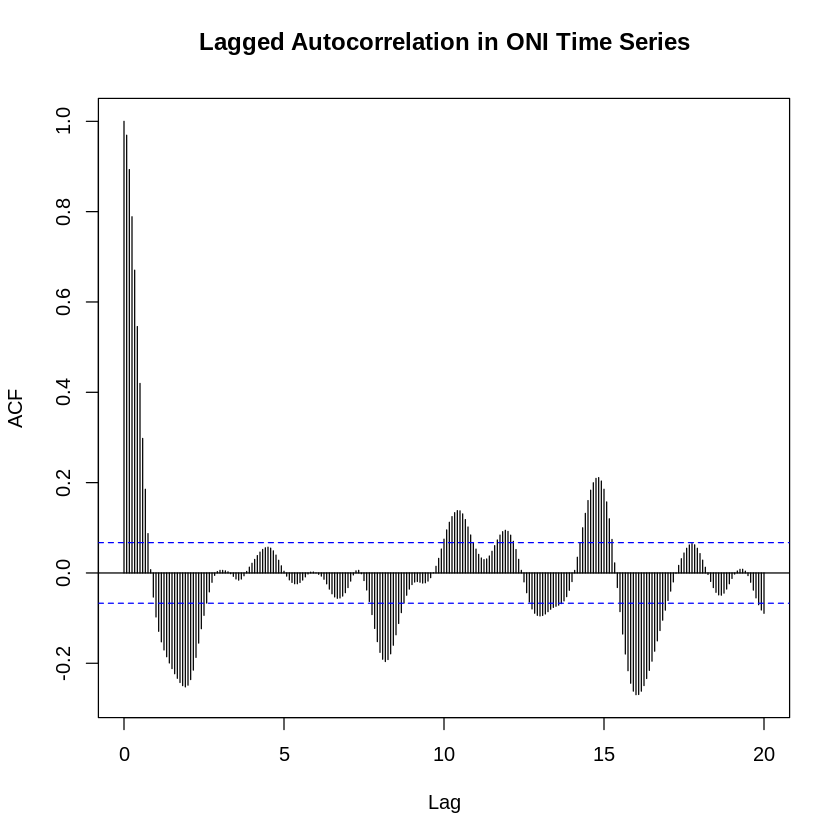

In [42]:
#maximum lag of 20 years
acf(oni.ts, type = "correlation", lag.max = 240, main = 'Lagged Autocorrelation in ONI Time Series')

While slight, there are some patterns we can gather from this, albeit on a longer time scale than the default periodogram can parse display. This confirms the idea that there is some autocorrelation at about 15 years of lag, where $\rho_t$ is about $.2$, and negative autocorrelation at about 2 and 17 years (which likely comes from the same trend). Next, we can see what conclusions can be reached with a periodogram.

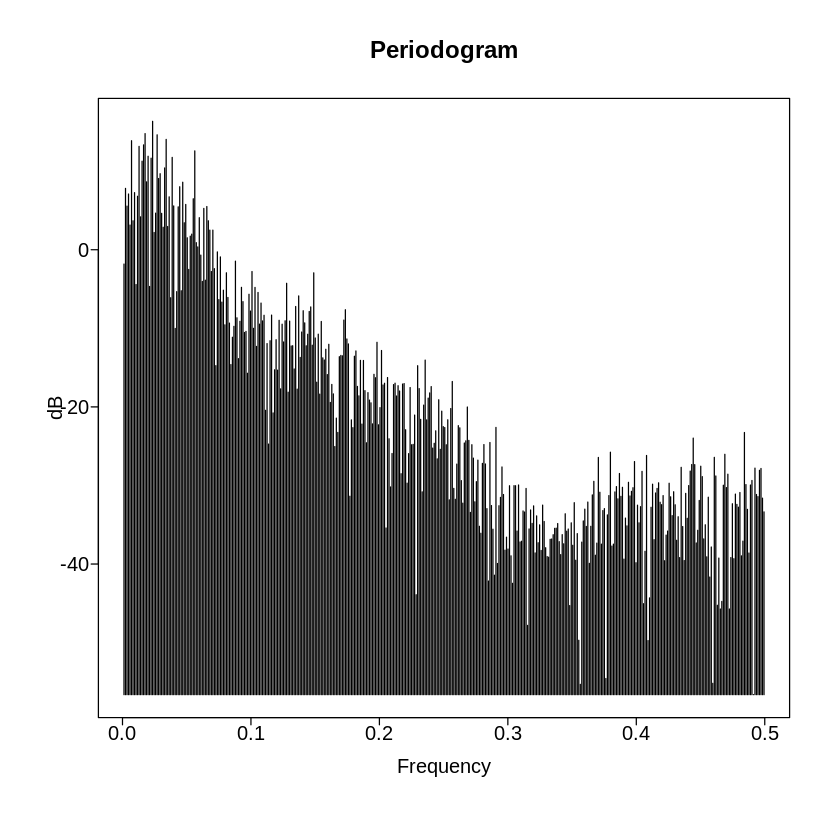

In [18]:
oni.period <- period.wge(oni.ts, dbcalc = T, plot = TRUE)

There isn't much which can be gleaned from this. The slow drop in dB to around zero is similar to what you would see with a random walk time series, impying no cyclic relationship at all. However, there may be some trends in the lower frequencies which we aren't capturing. Keep in mind that we are using monthly data on something which may have decade-long trends. We can try to display this data on yearly instead of monthly data to capture lower frequencies. As used in the paper, we can examine in the trends in the data taken in December through February, as "El Niño events tend to become apparent at the tail-end of calendar years" (Lam et al. 2019).

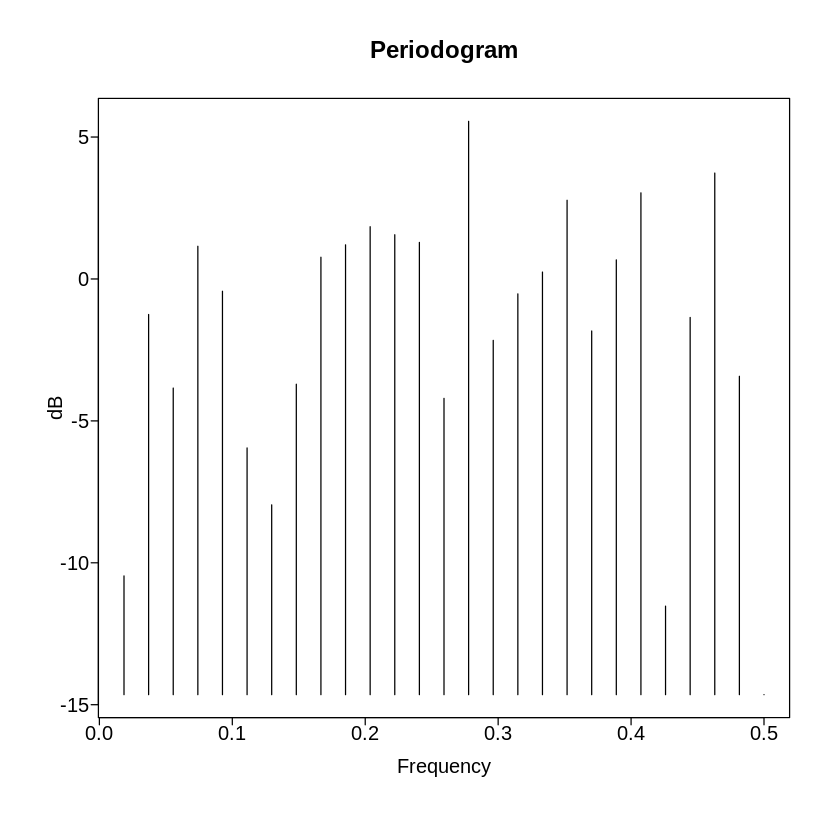

In [19]:
oni.filt.period <- period.wge(oni.filt$ANOM, dbcalc = T, plot = TRUE)

We still can't gather much from this. It's fair to say that there is some cyclical nature to ENSO as captured by ONI about every 15 years, but the correlation to support this is slight. We would need to confirm this using our other data: MEI.

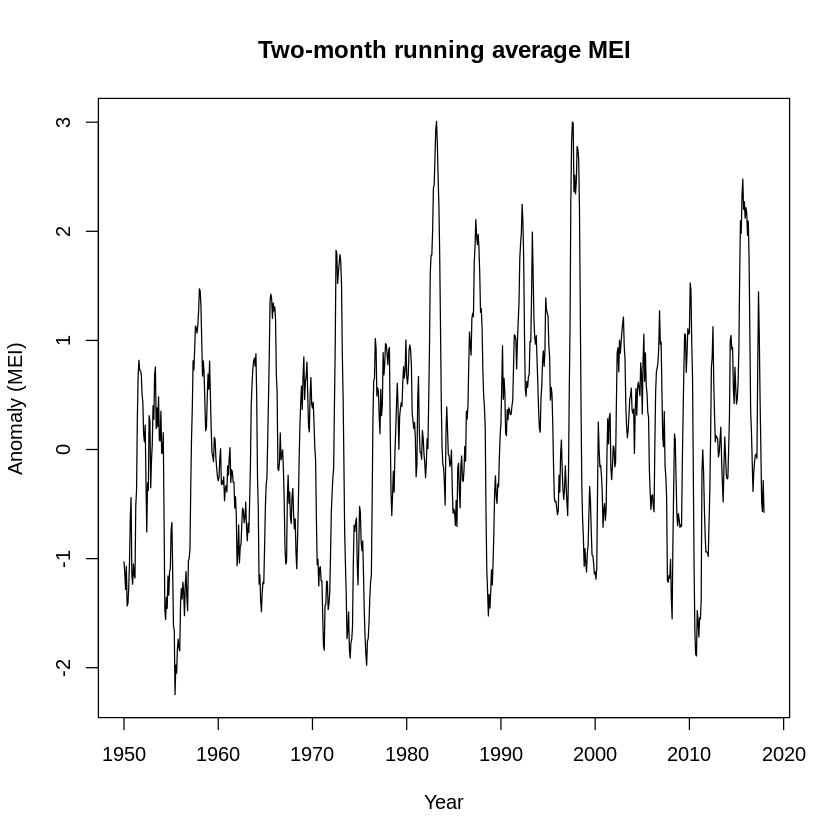

In [20]:
plot(mei.ts, main = "Two-month running average MEI", xlab = 'Year',ylab = 'Anomaly (MEI)')

This gives us another realization of the same underlying ENSO data. First, we will look at the lagged autocorrelation.

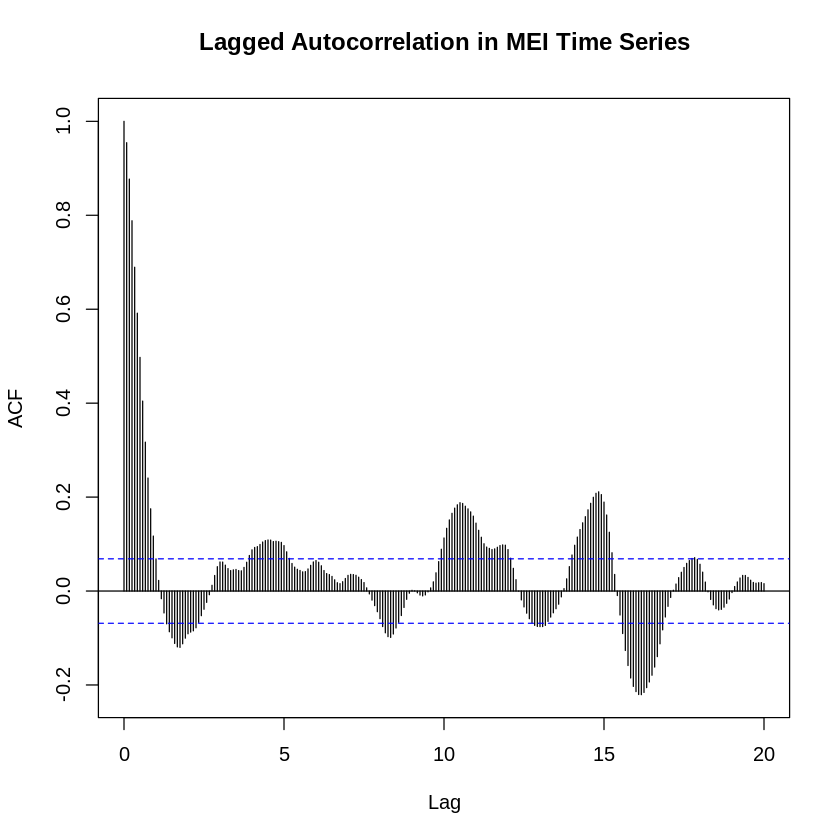

In [40]:
#Same 20 years as used for ONI
acf(mei.ts, type = "correlation", lag.max = 240, main = 'Lagged Autocorrelation in MEI Time Series') 

The patterns from this are similar to those we found in ONI. There is a more prominent peak around 11 years this time, but we still have our 15 year peak with a trough two years after. The strength of these correlations is about equal to those for ONI as well (about $\rho_t = 0.2$). While we couldn't gather anything from the periodogram for ONI, we should try for MEI as well.

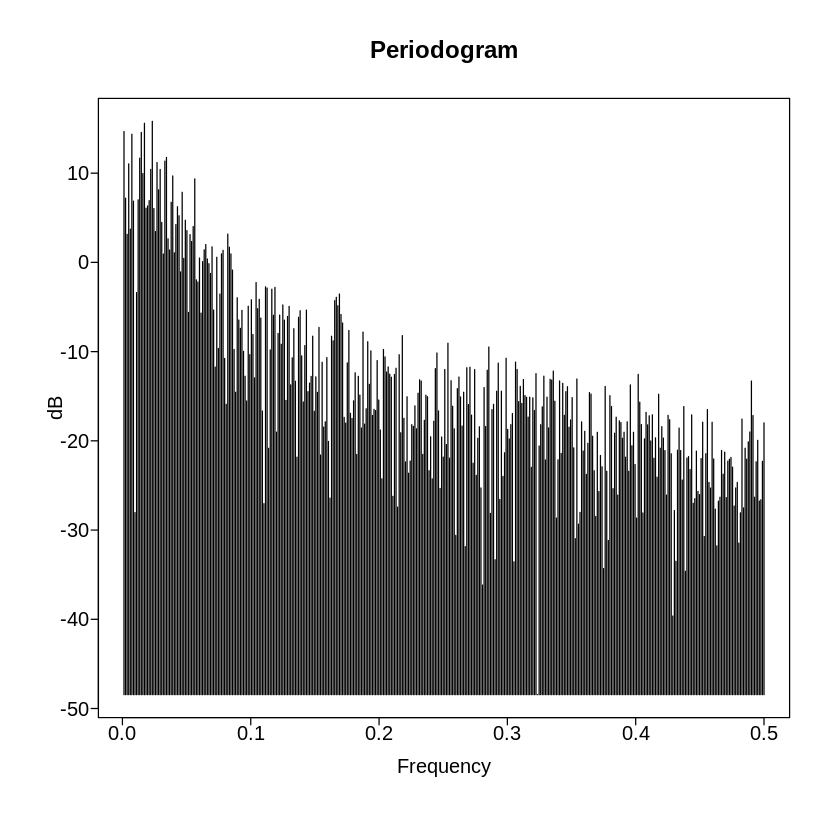

In [23]:
mei.period <- period.wge(mei.ts, dbcalc = T, plot = TRUE)

In [24]:
which.max(mei.period$pgram[2:length(mei.period$pgram)])
1/(mei.period$freq[18])

[1] 18

[1] 45.33333

Our strongest frequency is at 45.3 months, or about 3 years. This shows up on the graph of lagged autocorrelation as well, although it is not the highest peak. Once again, this appears very similar to a random walk. There may still be some small frequencies which would be easier to pick out with yearly data from Dec.-Jan.:

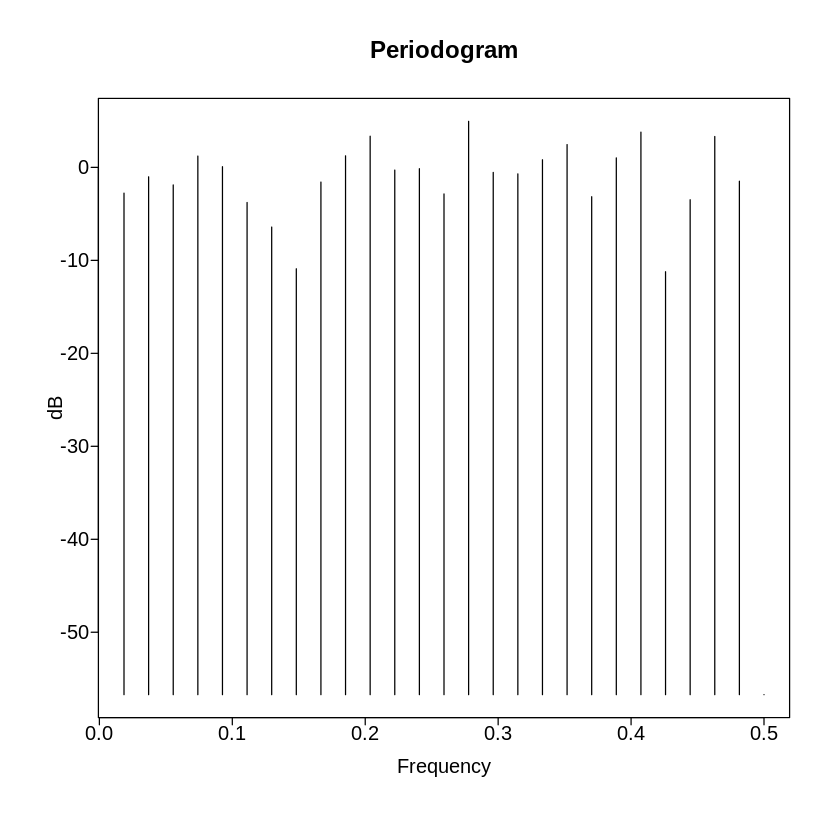

In [25]:
mei.filt.period <- period.wge(mei.filt, dbcalc = T, plot = TRUE)

Just like with ONI, this appears to just be noise.

Looking at the data for both realizations, it appears as though the primary frequency at which the ENSO cycle operates is between 14 and 15 years. Additionally, there is evidence that about 2 years after an El Niño event, there is a negative correlation in the anomaly. There is also some evidence of secondary frequencies at 3 to 5 years, although this is less strong.

Next, we will look at the PAD data.

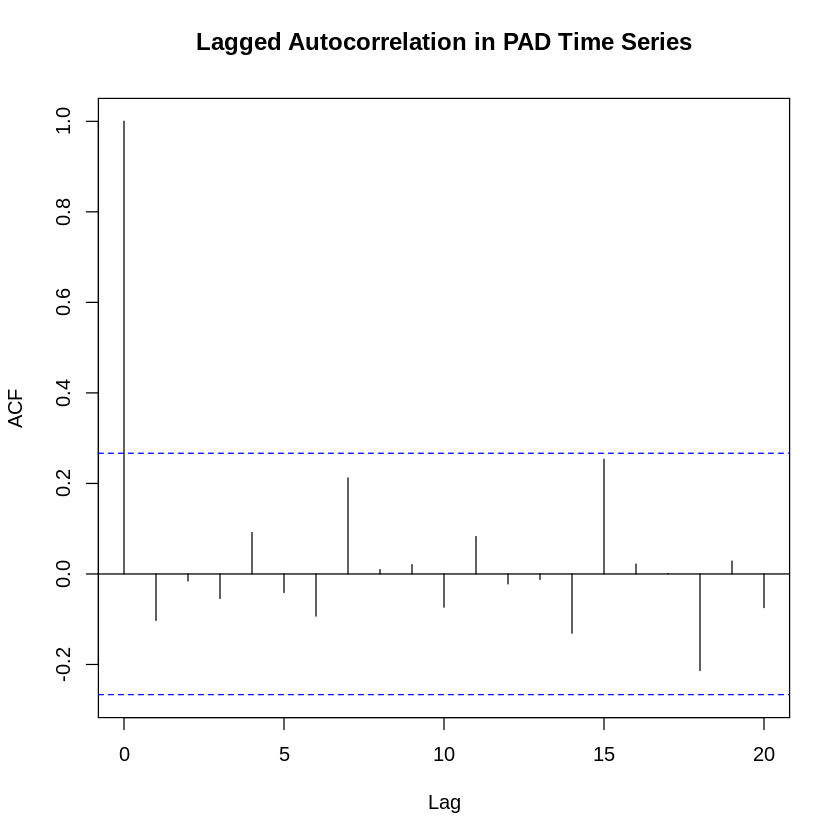

In [41]:
acf(pad.filt, lag.max = 20, main = 'Lagged Autocorrelation in PAD Time Series')

While there are fewer data points than we had in the ENSO data, there are still some interesting takeaways. Our highest peak is at 15 years, just like the ENSO data. In fact, this peak is similarly a little over $\rho_t = .2$. While more analysis would be needed to confirm this, it implies that the number of people affected by disasters follows the same trend, relative to time, as ENSO.

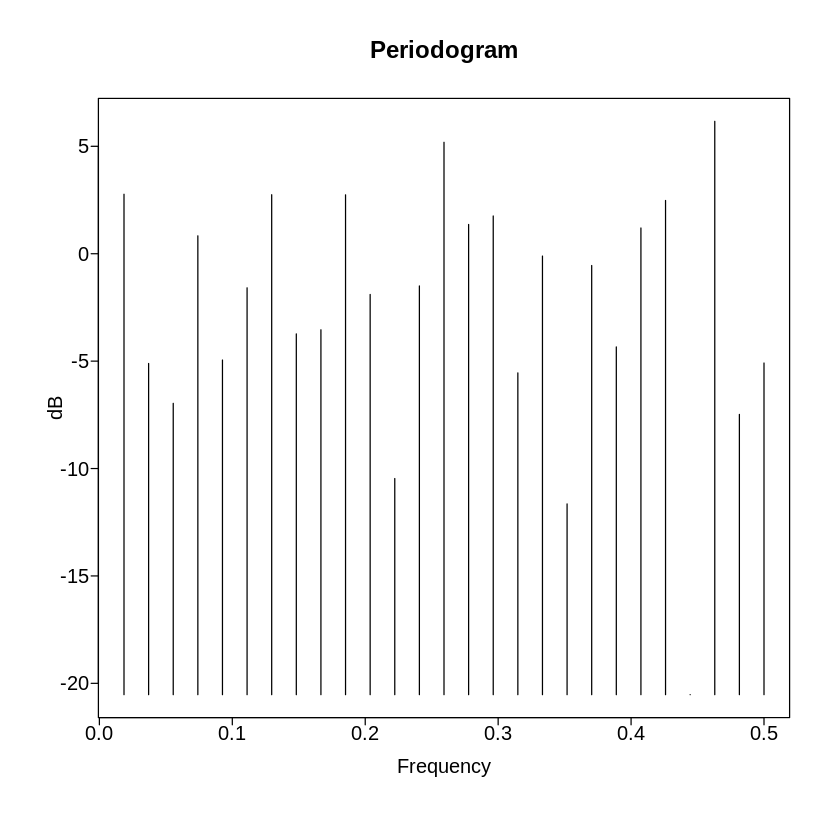

In [27]:
pad.period <- period.wge(pad.filt, dbcalc = T, plot = TRUE)

In [37]:
which.max(pad.period$pgram[0:20])
(pad.period$freq[14])
1/(pad.period$freq[14])

[1] 14

[1] 0.2592593

[1] 3.857143

Once again, there isn't much we can gather from the periodogram. The second strongest peak here is at a frequency of .259, or $T = 3.857$; the same 3-5 year cyclic pattern found with the ENSO data. It is fair to say that both the 15 year and 3-5 year periods in ENSO are reflected in the PAD data.

Let's move on to the Senate data.

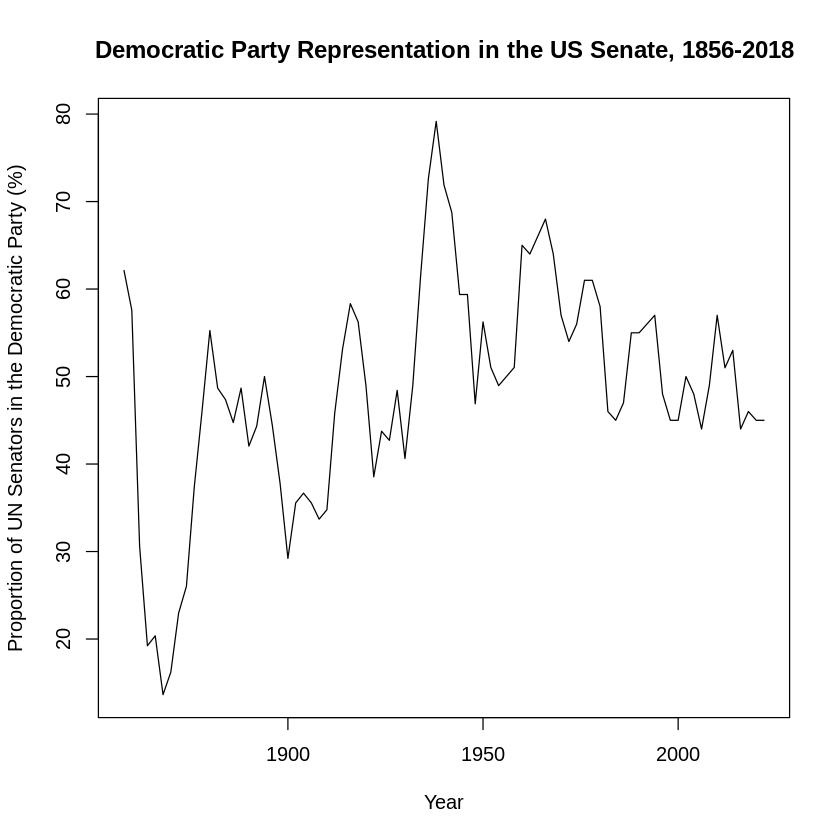

In [48]:
plot.ts(dem.ts, main = "Democratic Party Representation in the US Senate, 1856-2018", xlab = "Year", ylab = "Proportion of UN Senators in the Democratic Party (%)")

This is clearly not stationary data; the variance decreases significantly as $t$ increases. However, it seems as though there may be periodic behavior. We will first look at the periodogram.

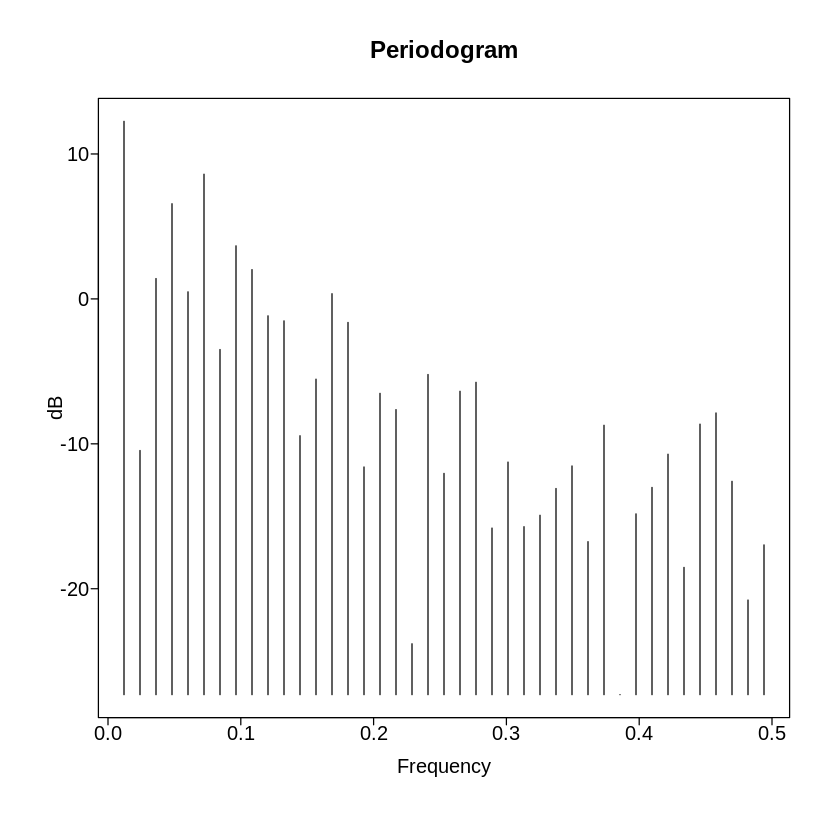

In [49]:
dem.period <- period.wge(dem.ts, dbcalc = T, plot = TRUE)

In [55]:
which.max(dem.period$pgram[2:5])
(dem.period$freq[4])
1/(dem.period$freq[4])

[1] 3

[1] 0.04819277

[1] 20.75

The most prominent frequency here is at $f = .0723$, or $T = 13.83$, measured in years. There is a secondary peak at $f = .0482$, or $T = 20.75$.

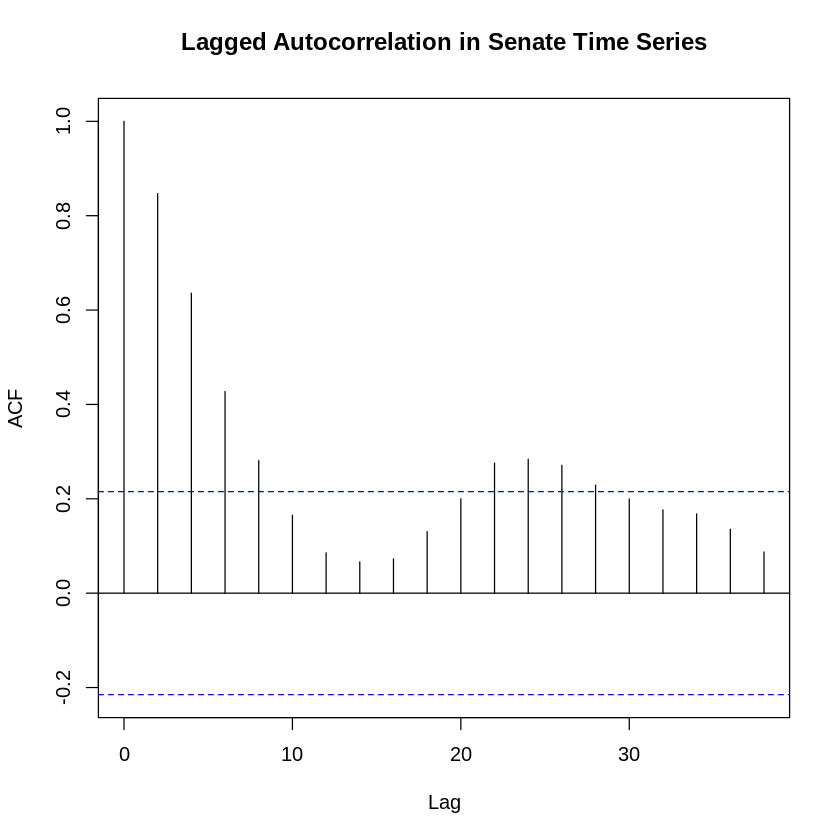

In [56]:
acf(dem.ts, type = "correlation", main = "Lagged Autocorrelation in Senate Time Series")

The lagged autocorrelation indicates a single dominant period around $T = 24$ years. Interestingly, the peak frequency we identified is the point with the lowest autocorrelation. However, once again, the periodogram appears noisy, to the point that the dominant frequencies identified from the periodogram could have simply been random noise.

## Discussion and Conclusions

In this lab, we examined the ENSO and disaster time series data used in the 2019 paper by Lam et al. First, we used the ENSO data from the ONI to identify El Niño event years. Then, we used time series analysis techniques, namely creating periodograms and examining lagged autocorrelational data, to find dominant frequencies of when El Nino events occurred. Next, we compared these findings to the PAD data and its dominant frequencies.


We found two rough dominant frequencies which appeared in all three time series, at around $T = 4$ and $T = 15$, measured in years. While not being very strongly correlated (around $\rho_t = .2$), this correlation and the frequency were consistent across the series. Additionally, in the ENSO data, we saw a negative autocorrelation with the data lagged at 2 years. This too was significant and consistent enough to suggest a valid relationship. Based on these findings, it is reasonable to say that if an El Niño event is occurring now, it is more likely that the same event will occur in 4 and 15 years, and more likely that the opposite event will occur in 2 and 17 years.


The dataset which I chose to analyze concerned the proportion of the US Senate which is made up of each major political party. I figured this data may display the same roughly cyclical nature that the ENSO data did. Upon analysis, there was conflicting evidence for different dominant periods, primarily $T = 14$ and $T = 24$ years. However, based on the autocorrelational lagged data, it seems as though the most likely peak is $T = 24$. Interestingly, the autocorrelation at this lag was $\rho = .3$; even higher than our El Niño data. 


One challenge which was persistent across each time series was the conflict between what the periodogram and lagged autocorrelation were suggesting. This is strange considering that the underlying data that they are showing is identical. I often found myself following the conclusion of the autocorrelation over that of the periodogram, simply because it had less noisy data which seemed to indicate that it was less influenced by random noise. I suppose this is also a side effect of using real world data, where the relationship being examined is often complex and less clear. I still believe that the conclusions reached were accurate.


## References

Lam, Holly Ching, et al. “Time-Series Study of Associations between Rates of People Affected by Disasters and the El Niño Southern Oscillation (ENSO) Cycle.” International Journal of Environmental Research and Public Health, vol. 16, no. 17, 2019, p. 3146., doi:10.3390/ijerph16173146. 

“SENATORS OF THE UNITED STATES.” United States Senate, 20 Jan. 2021, www.senate.gov/artandhistory/history/resources/pdf/chronlist.pdf. 

“US Politics: Democrat vs Republican Control of Congress and the Presidency: Political Party Overlays in Data Planet Statistical Datasets.” Data Planet LibGuides, 18 Nov. 2020, data-planet.libguides.com/politicalpartycontrol.

Climate Prediction Center - ENSO FAQ, 19 Dec. 2005, web.archive.org/web/20090827143632/www.cpc.noaa.gov/products/analysis_monitoring/ensostuff/ensofaq.shtml#DIFFER. 